In [2]:
# First cell
import os, sys
os.chdir("/kaggle/working")
!git clone https://github.com/DevasishY/uncertainty-hateful-memes.git
PROJECT_ROOT = "/kaggle/working/uncertainty-hateful-memes"
sys.path.insert(0, PROJECT_ROOT)


Cloning into 'uncertainty-hateful-memes'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 29 (delta 5), reused 24 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 376.65 KiB | 3.66 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [45]:
from src.data.load_hateful_memes import load_hateful_memes
from PIL import Image

train_df = load_hateful_memes("train")
dev_df = load_hateful_memes("dev")
test_df = load_hateful_memes("test")
train_df.sample(5)

Reading: /kaggle/input/hateful-memes-dataset/data/train.jsonl exists: True
Reading: /kaggle/input/hateful-memes-dataset/data/dev.jsonl exists: True
Reading: /kaggle/input/hateful-memes-dataset/data/test.jsonl exists: True


,id,img,label,text,img_path
1914,9843,img/09843.png,1,laughs in throwing gays from tall buildings!,/kaggle/input/hateful-memes-dataset/data/img/0...
3416,49328,img/49328.png,0,i'm going to be real honest with you you shoul...,/kaggle/input/hateful-memes-dataset/data/img/4...
5931,68193,img/68193.png,0,when you wore the wrong thawb,/kaggle/input/hateful-memes-dataset/data/img/6...
6351,76532,img/76532.png,1,trump supporters be like mexicans stole my teeth,/kaggle/input/hateful-memes-dataset/data/img/7...
6801,30714,img/30714.png,0,chicks be like the blacker the berry the sweet...,/kaggle/input/hateful-memes-dataset/data/img/3...


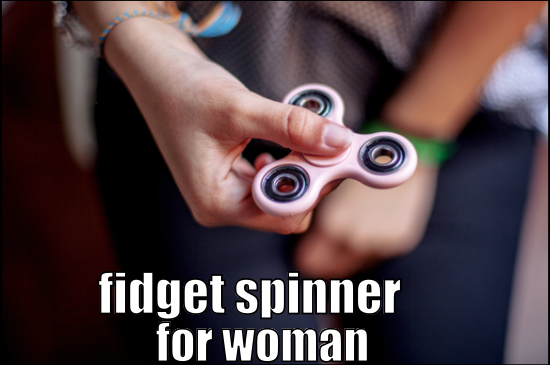

In [46]:
img = Image.open(train_df.iloc[918]["img_path"]).convert("RGB")
display(img)

In [9]:
!pip install -q "protobuf>=4.25.3,<5" transformers==4.44.0

In [47]:
from transformers import CLIPModel, CLIPTokenizerFast, CLIPProcessor
from PIL import Image
import torch

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to("cuda")
processor = CLIPProcessor.from_pretrained(model_name)

row = train_df.iloc[928]
image = Image.open(row["img_path"]).convert("RGB")
meme_text = row["text"]

inputs = processor(
    text=meme_text,
    images=image,
    return_tensors="pt",
    padding=True
).to("cuda")

with torch.no_grad():
    outputs = model(**inputs)
    # image & text embeddings are now in outputs.image_embeds and outputs.text_embeds[web:110]


In [48]:
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds

print(image_embeds.shape)
print(text_embeds.shape)

torch.Size([1, 512])
torch.Size([1, 512])


In [49]:
image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
text_embeds  = text_embeds  / text_embeds.norm(dim=-1, keepdim=True)

similarity = (image_embeds @ text_embeds.T)  # cosine similarity
print(similarity.item())

# there is not much similarity between text and meme,when it is useful, to find out on what part of image+text CLIP is concentrating 

0.24636638164520264


In [50]:
labels = ["a hateful meme", "a non-hateful meme"]

inputs = processor(
    text=labels,
    images=[image],
    return_tensors="pt",
    padding=True
).to(device)

with torch.no_grad():
    out = model(**inputs)
    logits_per_image = out.logits_per_image[0]      # shape [2]
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    print(dict(zip(labels, probs)))


{'a hateful meme': 0.36660212, 'a non-hateful meme': 0.6333979}


In [53]:
# embedding function to get all samples embeddings at once 
import numpy as np
def embed_memes(df, max_n=None):
    if max_n is not None:
        df = df.sample(max_n).copy()
    all_embeds = []
    for _, row in df.iterrows():
        img = Image.open(row["img_path"]).convert("RGB")
        txt = row["text"]

        inputs = processor(text=[txt], images=[img],
                           return_tensors="pt", padding=True, truncation= True, max_length=77).to(device)
        with torch.no_grad():
            out = model(**inputs)
        img_e = out.image_embeds[0]
        txt_e = out.text_embeds[0]
        emb = torch.cat([img_e, txt_e])       # simple concat multimodal [image(512) : text(512)]
        all_embeds.append(emb.cpu().numpy())
    return np.vstack(all_embeds)

In [54]:
X_train = embed_memes(train_df)   # or full if time allows
y_train = train_df["label"].values

X_dev   = embed_memes(dev_df)
y_dev   = dev_df["label"].values

X_test  = embed_memes(test_df)


In [57]:
print(X_train.shape) # embedding of shape [no of samples, 2x512] 
print(X_dev.shape)
print(X_test.shape)


(8500, 1024)
(500, 1024)
(1000, 1024)
